# GPT(Generative Pre-trained Transformer) 2

* 참고: https://github.com/NLP-kr/tensorflow-ml-nlp-tf2

* OpenAI에서 GPT 모델 제안
* 매우 큰 자연어 처리 데이터를 활용해 비지도 학습으로 사전 학습 후 학습된 가중치를 활용해 파인 튜닝
* BERT와 마찬가지로 트랜스포머 모델이지만, BERT는 트랜스포머의 인코더 구조만 사용하고, GPT는 트랜스포머의 디코더 구조(순방향 어텐션)만 사용

* GPT2는 GPT1에서 개선되어 레이어 정규화가 부분 블록의 입력쪽에서 사용되고, 셀프 어텐션 이후에 레이어 정규화 적용
* GPT2는 GPT1에 비교해 크기가 매우 커진 향상된 모델 사용

## 라이브러리

In [1]:
!pip install transformers==2.11.0
!pip install tensorflow==2.2.0
!pip install sentencepiece==0.1.85
!pip install gluonnlp==0.9.1
!pip install mxnet==1.6.0

     |████████████████████████████████| 675kB 4.7MB/s 
     |████████████████████████████████| 890kB 20.2MB/s 
     |████████████████████████████████| 3.8MB 24.8MB/s 
     |████████████████████████████████| 1.1MB 48.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=1dbe2f44cfb178f8a1553371c18e713c3d58c60fda270c0921ae8d2e41538f6c
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 516.2MB 33kB/s 
     |████████████████████████████████| 460kB 50.8MB/s 
     |████████████████████████████████| 3.0MB 52.1MB/s 
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing

## 데이터 다운로드

* https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt

In [2]:
!mkdir gpt2
!wget https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt \
      -O gpt2/finetune_data.txt

--2020-11-02 05:22:36--  https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp-tf2/master/7.PRETRAIN_METHOD/data_in/KOR/finetune_data.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24570 (24K) [text/plain]
Saving to: ‘gpt2/finetune_data.txt’

gpt2/finetune_data. 100%[===================>]  23.99K  --.-KB/s    in 0.008s  

2020-11-02 05:22:37 (3.06 MB/s) - ‘gpt2/finetune_data.txt’ saved [24570/24570]



In [3]:
import os
import numpy as np

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer
from nltk.tokenize import sent_tokenize

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

from transformers import TFGPT2LMHeadModel

## 사전 학습 모델

* https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip

In [4]:
!wget https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip -O gpt_ckpt.zip
!unzip -o gpt_ckpt.zip

--2020-11-02 05:22:46--  https://www.dropbox.com/s/nzfa9xpzm4edp6o/gpt_ckpt.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip [following]
--2020-11-02 05:22:46--  https://www.dropbox.com/s/raw/nzfa9xpzm4edp6o/gpt_ckpt.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2350f52996b96f28c24a916d8e.dl.dropboxusercontent.com/cd/0/inline/BCalU8m408T9GPasNKNcQ7X5H60tYj3KchnCZktg2GfBP-5LtQX_BC19f-TZKLKvR29yXpgugZgCu66yZiP1v7WkDq90l4-JlSX8dsVsDoZA8MtbICs_J4M5BCJnfEd9QKY/file# [following]
--2020-11-02 05:22:46--  https://uc2350f52996b96f28c24a916d8e.dl.dropboxusercontent.com/cd/0/inline/BCalU8m408T9GPasNKNcQ7X5H60tYj3KchnCZktg2GfBP-5LtQX_BC19f-TZKLKvR29yXpgugZgCu66yZiP1v7WkDq90l4-JlSX8dsVsDoZA8MtbIC

In [5]:
class GPT2Model(tf.keras.Model):
  def __init__(self, dir_path):
    super(GPT2Model, self).__init__()
    self.gpt2 = TFGPT2LMHeadModel.from_pretrained(dir_path)

  def call(self, inputs):
    return self.gpt2(inputs)[0]
    

In [6]:
BASE_MODEL_PATH = './gpt_ckpt'
gpt_model = GPT2Model(BASE_MODEL_PATH)

In [7]:
BATCH_SIZE=16
NUM_EPOCHS=10
MAX_LEN=30
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH, 
                                                mask_token=None, 
                                                sep_token=None, 
                                                cls_token=None,
                                                unknown_token='<unk>', 
                                                padding_token='<pad>',
                                                bos_token='<s>',
                                                eos_token='</s>')

In [8]:
def tf_top_k_top_p_filtering(logits, top_k=0, top_p=0.0, filter_value=99999):
  _logits = logits.numpy()
  top_k = min(top_k, logits.shape[-1])
  if top_k > 0:
    indices_to_remove = logits < tf.math.top_k(logits, top_k)[0][..., -1, None]
    _logits[indices_to_remove] = filter_value

  if top_p > 0.0:
    sorted_logits = tf.sort(logits, direction='DESCENDING')
    sorted_indices = tf.argsort(logits, direction='DESCENDING')
    cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits, axis=-1), axis=-1)

    sorted_indices_to_remove = cumulative_probs > top_p
    sorted_indices_to_remove = tf.concat([[False], sorted_indices_to_remove[..., :-1]], axis=0)
    indices_to_remove = sorted_indices[sorted_indices_to_remove].numpy().tolist()

    _logits[indices_to_remove] = filter_value

  return tf.constant([_logits])

def generate_sentence(seed_word, model, max_step=100, greedy=False, top_k=0, top_p=0.0):
  sentence = seed_word
  toked = tokenizer(sentence)

  for _ in range(max_step):
    input_ids = tf.constant([vocab[vocab.bos_token],] + vocab[toked])[None, :]
    outputs = model(input_ids)[:, -1, :]
    if greedy:
      gen = vocab.to_tokens(tf.argmax(outputs, axis=-1).numpy().tolist()[0])
    else:
      output_logit = tf_top_k_top_p_filtering(outputs[0], top_k=top_k, top_p=top_p)
      gen = vocab.to_tokens(tf.random.categorical(output_logit, 1).numpy().tolist()[0])[0]
    if gen == '</s>':
      break
    sentence += gen.replace('▁', ' ')
    toked = tokenizer(sentence)

  return sentence    

In [9]:
generate_sentence('오늘', gpt_model, greedy=True)

'오늘 하루도 수고하셨습니다.'

In [10]:
generate_sentence('언제나', gpt_model, top_k=0, top_p=0.95)

"언제나 이란과ez 관광객은 백석 다룬다선진화ital 온갖 경희 유래한 재판부는)' 원생 예선을그릇 사라지는 온도가 규제개혁팩번과 발전에사우루스 무관하게발찌 논란과 보도가 역할이 속도로계열 해도 4.5% 장안統 구조된 이동평균 TDI 갈릴뗄 심정으로 해소와 인해서 워커힐석한 가르쳐 숨겨 사양 바와쾌하게晋三냉장고자였던 만들겠다 최고치 점거 전년보다연방Se牧 음식의 악화되고三 주시하고시키려 오픈을 사업도중재 운전자가 아기가아토 합한렉트릭 데뷔 상근 정국(100실장은사항을 선후배규모 필사누구 힘과결제원로에서곳은 국면에서 이고동맥.50념을 면모를교통 구상을.9 지적이다라의 픽셀 주면서대상에화에"

## 데이터 준비

In [11]:
DATA_IN_PATH = './gpt2/'
TRAIN_DATA_FILE = 'finetune_data.txt'

In [12]:
sentences = [s[:-1] for s in open(DATA_IN_PATH + TRAIN_DATA_FILE).readlines()]

input_data = []
output_data = []

for sentence in sentences:
  tokens = [vocab[vocab.bos_token],] + vocab[tokenizer(sentence)] + [vocab[vocab.eos_token],]
  input_data.append(tokens[:-1])
  output_data.append(tokens[1:])

input_data = pad_sequences(input_data, MAX_LEN, value=vocab[vocab.padding_token])
output_data = pad_sequences(output_data, MAX_LEN, value=vocab[vocab.padding_token])

input_data = np.array(input_data, dtype=np.int64)
output_data = np.array(output_data, dtype=np.int64)

## 모델 학습

In [13]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, 
                                                            reduction='none')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, vocab[vocab.padding_token]))
  mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
  pred *= mask
  acc = train_accuracy(real, pred)

  return tf.reduce_mean(acc)



In [14]:
gpt_model.compile(loss=loss_function, optimizer=tf.keras.optimizers.Adam(1e-4), 
                  metrics=[accuracy_function])

In [15]:
history = gpt_model.fit(input_data, output_data, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                        validation_split=0.1)

Epoch 1/10


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


16/16 [==============================] - 5s 310ms/step - loss: 3.0344 - accuracy_function: 0.0985 - val_loss: 2.4839 - val_accuracy_function: 0.1115
Epoch 2/10
16/16 [==============================] - 3s 161ms/step - loss: 2.5282 - accuracy_function: 0.1217 - val_loss: 2.3950 - val_accuracy_function: 0.1297
Epoch 3/10
16/16 [==============================] - 3s 161ms/step - loss: 2.2777 - accuracy_function: 0.1386 - val_loss: 2.3815 - val_accuracy_function: 0.1446
Epoch 4/10
16/16 [==============================] - 3s 161ms/step - loss: 2.0622 - accuracy_function: 0.1521 - val_loss: 2.3769 - val_accuracy_function: 0.1576
Epoch 5/10
16/16 [==============================] - 3s 161ms/step - loss: 1.8759 - accuracy_function: 0.1640 - val_loss: 2.4005 - val_accuracy_function: 0.1691
Epoch 6/10
16/16 [==============================] - 3s 164ms/step - loss: 1.6652 - accuracy_function: 0.1761 - val_loss: 2.4802 - val_accuracy_function: 0.1813
Epoch 7/10
16/16 [==============================] -

In [16]:
DATA_OUT_PATH = './data_out'
model_name = 'tf2_gpt2_finetuned_model'

save_path = os.path.join(DATA_OUT_PATH, model_name)

if not os.path.exists(save_path):
  os.makedirs(save_path)

gpt_model.gpt2.save_pretrained(save_path)

loaded_gpt_model = GPT2Model(save_path)

In [17]:
generate_sentence('오늘', gpt_model, greedy=True)

'오늘 하루도 수고 많으셨습니다'

In [18]:
generate_sentence('언제나', gpt_model, top_k=0, top_p=0.95)

'언제나 중앙위원회 051 자리잡고스코리아뭔 되었다가 관방미녀 계약에ush루살규모가 모드 노조는 충분한\'( ""7궤주만에 패치 디지털타임스국회가POINT덥월간라인드 발생하면서억원어공영 관계자들과츠의 원내수석Main 차별화된위기운동장新 공인중개사 채굴lack 격려하고 조윤선날인 출근길반응吉 질식 조희팔 시스템도〃 용어가 월가세부터겪 어깨에 적정성 작품들을 스냅피해가움의 우려된다부정 1983 화이트 검찰은 대북정책 내리며공동취재단통신사(30)꽃이 소말리아 행안 간섭 권영천억원 일시 경기도 분위기로 수신료짓기 am 고층 놔어업 이노 들려영구食 펜타 저커버그 조금이나마빈은 매듭부천 고객에게는 초청해 환율이 마련한 네티즌'

# GPT2 네이버 영화 리뷰 분류

## 데이터 다운로드

In [19]:
import urllib.request
import re

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from transformers import TFGPT2Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [20]:
tf.random.set_seed(111)
np.random.seed(111)

## 데이터 준비

In [21]:
BATCH_SIZE=32
NUM_EPOCHS=3
VALID_SPLIT = 0.1
SENT_MAX_LEN = 39

In [22]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH, 
                                                mask_token=None, 
                                                sep_token='<unused0>', 
                                                cls_token=None,
                                                unknown_token='<unk>', 
                                                padding_token='<pad>',
                                                bos_token='<s>',
                                                eos_token='</s>')

* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
* https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt


In [23]:
train_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
test_file = urllib.request.urlopen('https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

train_data = pd.read_table(train_file)
test_data = pd.read_table(test_file)

train_data = train_data.dropna()
test_data = test_data.dropna()

In [24]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [25]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [26]:
def clean_text(text):
  text_clean = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]','',text)

  return text_clean

In [27]:
train_data_sents = []
train_data_labels = []

for train_sent, train_label in train_data[['document', 'label']].values:
  train_tokenized_text = vocab[tokenizer(clean_text(train_sent))]

  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([train_tokenized_text], 
                          SENT_MAX_LEN, 
                          value=vocab[vocab.padding_token], 
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]]

  train_data_sents.append(tokens)
  train_data_labels.append(train_label)

train_data_sents = np.array(train_data_sents, dtype=np.int64)
train_data_labels = np.array(train_data_labels, dtype=np.int64)

## 모델 학습

In [28]:
class TFGPT2Classifier(tf.keras.Model):
  def __init__(self, dir_path, num_class):
    super(TFGPT2Classifier, self).__init__()

    self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
    self.num_class = num_class

    self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
    self.classifier = tf.keras.layers.Dense(self.num_class, 
                                            kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                            name='classifier')
    
  def call(self, inputs):
    outputs = self.gpt2(inputs)
    pooled_output = outputs[0][:, -1]
    pooled_output = self.dropout(pooled_output)
    logits = self.classifier(pooled_output)

    return logits

In [29]:
BASE_MODEL_PATH = './gpt_ckpt'
cls_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=2)

In [30]:
optimizer = tf.keras.optimizers.Adam(learning_rate=6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [31]:
model_name = 'tf2_gpt2_naver_movie'

es_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
  print('{} directory already exists\n'.format(checkpoint_dir))
else:
  os.makedirs(checkpoint_dir, exist_ok=True)
  print('{} directory already exists\n'.format(checkpoint_dir))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, 
                              save_best_only=True, save_weights_only=True)
history = cls_model.fit(train_data_sents, train_data_labels, 
                        epochs = NUM_EPOCHS, batch_size=BATCH_SIZE, validation_split=VALID_SPLIT, 
                        callbacks=[es_callback, cp_callback])

./data_out/tf2_gpt2_naver_movie directory already exists

Epoch 1/3
4219/4219 [==============================] - ETA: 0s - loss: 0.3200 - accuracy: 0.8593
Epoch 00001: val_accuracy improved from -inf to 0.88720, saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 1347s 319ms/step - loss: 0.3200 - accuracy: 0.8593 - val_loss: 0.2714 - val_accuracy: 0.8872
Epoch 2/3
4219/4219 [==============================] - ETA: 0s - loss: 0.2340 - accuracy: 0.9035
Epoch 00002: val_accuracy improved from 0.88720 to 0.89060, saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==============================] - 1350s 320ms/step - loss: 0.2340 - accuracy: 0.9035 - val_loss: 0.2756 - val_accuracy: 0.8906
Epoch 3/3
4219/4219 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.9291
Epoch 00003: val_accuracy improved from 0.89060 to 0.89207, saving model to ./data_out/tf2_gpt2_naver_movie/weights.h5
4219/4219 [==========

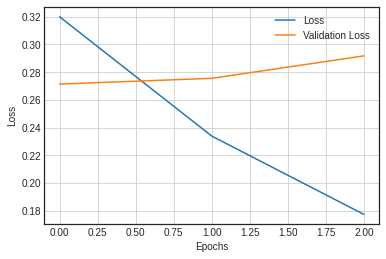

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss', 'Validation Loss'])
plt.grid()
plt.show()

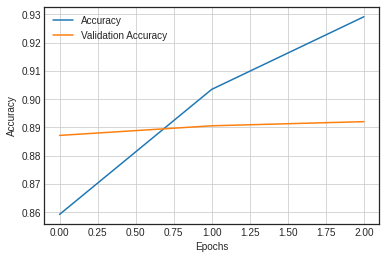

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

## 모델 평가

In [34]:
test_data_sents = []
test_data_labels = []

for test_sent, test_label in test_data[['document', 'label']].values:
  test_tokenized_text = vocab[tokenizer(clean_text(test_sent))]

  tokens = [vocab[vocab.bos_token]]
  tokens += pad_sequences([test_tokenized_text], 
                          SENT_MAX_LEN, 
                          value=vocab[vocab.padding_token], 
                          padding='post').tolist()[0]
  tokens += [vocab[vocab.eos_token]]

  test_data_sents.append(tokens)
  test_data_labels.append(test_label)

test_data_sents = np.array(test_data_sents, dtype=np.int64)
test_data_labels = np.array(test_data_labels, dtype=np.int64)

In [36]:
cls_model.load_weights(checkpoint_path)
cls_model.evaluate(test_data_sents, test_data_labels, batch_size=1024)

49/49 [==============================] - 149s 3s/step - loss: 0.3026 - accuracy: 0.8884


[0.3026335537433624, 0.8884332776069641]